In [1]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from dateutil import relativedelta
from datetime import datetime
import re
import tqdm

In [2]:

con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()


In [3]:
cur.execute("select id, name, abbreviation, matching_certainty from authors")
rows = cur.fetchall()
authors = pd.DataFrame(columns=["id", "name", "abbreviation", "certainty"], data=rows)
authors.set_index("id", inplace=True)

In [4]:
# convert null to nans
authors = authors.replace("null", np.nan)

In [5]:
# set certainty of a row to the average certainty over all rows with same name and abbreviation, ignore nan values
mean_certainty = authors.groupby(["name", "abbreviation"])["certainty"].transform(lambda x: np.nanmean(x))
authors["certainty"] = mean_certainty

In [6]:
authors["name_pointing_to_abbreviation_count"] = authors.groupby(["name", "abbreviation"])["name"].transform("count")
authors["abbreviation_pointing_to_name_count"] = authors.groupby(["name", "abbreviation"])["abbreviation"].transform("count")

In [7]:
# drop duplicates based on name, abbreviation, certainty. I can drop them because ..._count saved the count
authors.drop_duplicates(subset=["name", "abbreviation", "certainty"], inplace=True)

In [8]:
# set the share that the name has of all names that point to that abbreviation
authors_with_name_pointing_to_abbreviation_sum =  authors.groupby(["abbreviation"]).agg(names_pointing_to_abbreviation_sum=("name_pointing_to_abbreviation_count", "sum")).reset_index()
authors = pd.merge(authors, authors_with_name_pointing_to_abbreviation_sum, on="abbreviation")
authors["name_pointing_to_abbreviation_share"] = authors["name_pointing_to_abbreviation_count"] / authors["names_pointing_to_abbreviation_sum"]

In [9]:
# set the share that the abbreviation has of all abbreviations that point to that name
authors_with_abbreviation_pointing_to_name_sum = authors.groupby(["name"]).agg(abbreviations_pointing_to_name_sum=("abbreviation_pointing_to_name_count", "sum")).reset_index()
authors = pd.merge(authors, authors_with_abbreviation_pointing_to_name_sum, on="name")
authors["abbreviation_pointing_to_name_share"] = authors["abbreviation_pointing_to_name_count"] / authors["abbreviations_pointing_to_name_sum"]

In [10]:
# calculate a final score for the weighted edge between name and abbreviation
authors["score"] = authors["certainty"] + authors["name_pointing_to_abbreviation_share"] + authors["abbreviation_pointing_to_name_share"]

In [11]:
# reduce the problem space to a bipartite graph, assigning all (name, abbreviation) pairs that are not connected to the graph as final/solved
# add pairs to final mapping where abbreviation_pointing_to_name_count == 1 or name_pointing_to_abbreviation_count == 1 and remove those from the authors 
#one_to_one_mappings = authors[(authors["abbreviations_pointing_to_name_sum"] == 1) & (authors["names_pointing_to_abbreviation_sum"] == 1)]
#final_mapping = pd.concat([final_mapping, one_to_one_mappings[["name", "abbreviation"]]], ignore_index=True)

#authors = authors[(authors["abbreviations_pointing_to_name_sum"] != 1) | (authors["names_pointing_to_abbreviation_sum"] != 1)]

In [12]:
authors = authors[authors["name"] != "A. Krieger"]


In [13]:
# remove self referencing nodes
authors = authors[authors["name"] != authors["abbreviation"]]

In [14]:
# add name and abbreviation as nodes list and remove duplicates
nodes = list(authors["name"].unique()) + list(authors["abbreviation"].unique())

# add unique edges based on entries in the authors table
edges = []
for index, row in authors.iterrows():
    edges.append((row["name"], row["abbreviation"]))

In [15]:
G = nx.Graph()
G.clear()
author_list = list(authors["name"].unique())
abbr_list = list(authors[authors["name"].isin(author_list)]["abbreviation"].unique())
G.add_nodes_from(author_list, bipartite=0)
G.add_nodes_from(abbr_list, bipartite=1)
dummy_nodes = [f"{name}_dummy" for name in author_list]
G.add_nodes_from(dummy_nodes, bipartite=1)

edges = []
for index, row in authors[authors["name"].isin(author_list) & authors["abbreviation"].isin(abbr_list)].iterrows():
    G.add_edges_from([(row["name"], row["abbreviation"])], weight=round(row["score"],2) * -1)

for name in author_list:
    G.add_edges_from([(name, f"{name}_dummy")], weight=0)


In [16]:
new_edges = nx.bipartite.minimum_weight_full_matching(G, top_nodes=list(authors["name"].unique()), weight="weight")
g_new = nx.Graph()
g_new.clear()
g_new.add_nodes_from(author_list, bipartite=0)
g_new.add_nodes_from(abbr_list, bipartite=1)
g_new.add_edges_from(new_edges.items())

In [17]:
g_new.edges

EdgeView([('Kai-Uwe Brandt', 'kub'), ('Jan Peter', 'jap'), ('Manfred Lüttich', 'malü'), ('März Frank Pfütze', 'März Frank Pfütze_dummy'), ('Magdalena Froehlich', 'mf'), ('Michael Frömmert', 'maf'), ('Heiko Trebs', 'ht'), ('Andreas Tappert', 'art'), ('Annett Riedel', 'ar'), ('Angelika Raulien', 'arau'), ('Andrea Richter', 'Andrea Richter_dummy'), ('Nadja Topfstedt', 'dpe'), ('Norbert Töpfer', 'nt'), ('Niklas Tolkamp', 'Niklas Tolkamp_dummy'), ('Thomas Lang', 'thlang'), ('Thomas Haegeler', 'thl'), ('Antje Henselin-Rudolph', 'ahr'), ('Lutz Schmidt', 'ls'), ('Nico Fliegner', 'nf'), ('Heike Liesaus', 'hl'), ('Juliane Streich', 'just'), ('Ulrike Sauer', 'Ulrike Sauer_dummy'), ('Lisa Garn', 'Lisa Garn_dummy'), ('Lisa Berins', 'lisa'), ('Lisa Seliger', 'lis'), ('Melanie Steitz', 'mes'), ('Lisa Schliep', 'liss'), ('Laurine Schubert', 'Laurine Schubert_dummy'), ('Kendra Reinhardt', 'kir'), ('Karoline Maria Keybe', 'key'), ('Kinderwerkstatt anmeldet', 'Kinderwerkstatt anmeldet_dummy'), ('Kommenta

In [18]:
print(f"new graph has {len(g_new.nodes)} nodes and {len(g_new.edges)} edges")

new graph has 1400 nodes and 593 edges


In [19]:
# transform graph to dataframe author_mapping with columns name and abbreviation
author_mapping = pd.DataFrame(columns=["name", "abbreviation"], data=g_new.edges)
author_mapping = author_mapping.astype(str)

print(f"author_mapping has {author_mapping.shape[0]} rows")


# remove all abbreviations that contain "dummy" in their name
author_mapping = author_mapping[~author_mapping["abbreviation"].str.contains("dummy")]
# print shape
print(f"author_mapping has {author_mapping.shape[0]} rows")

author_mapping has 593 rows
author_mapping has 483 rows


### In the following there are some analyses covering the correctness of the approach

In [20]:
def has_special_umlauts(input_string):
    umlaut_pattern = re.compile(r'[äöüÄÖÜßáéíóú]')
    return bool(umlaut_pattern.search(input_string))

# test if there is an authors that was mapped to an abbreviation that exceeds the authors name writing time by more than 6 months in the time before or after
count = 0
author_abbreviation_pairs_with_lifespan_difference = []
for index, row in author_mapping.iterrows():
    author = row["name"]
    if has_special_umlauts(author):
        # do not handle authors with umlauts because issues with sqlite LIKE operator
        continue
    abbreviation = row["abbreviation"]
    author_like = f"%\"{author}\"%"
    abbr_like = f"%\"{abbreviation}\"%"
    try:
        first_article_author = cur.execute(f"SELECT MIN(published_at) FROM articles where author_array like ?", (author_like,)).fetchone()[0]
        first_article_abbr = cur.execute(f"SELECT MIN(published_at) FROM articles where author_array like ?", (abbr_like,)).fetchone()[0]
        first_article_author = datetime.strptime(first_article_author, "%Y-%m-%dT%H:%M:%S+00:00")
        first_article_abbr = datetime.strptime(first_article_abbr, "%Y-%m-%dT%H:%M:%S+00:00")

        # check if first_article_abbr is six month ahead of first_article_author
        if first_article_abbr < first_article_author - relativedelta.relativedelta(months=12):
            print(f"author: {author}, first_article_author: {first_article_author}, abbreviation: {abbreviation}, first_article_abbr: {first_article_abbr}")
            count += 1
            author_abbreviation_pairs_with_lifespan_difference.append({"author": author, "abbreviation": abbreviation})

        last_article_author = cur.execute(f"SELECT MAX(published_at) FROM articles where author_array like ?", (author_like,)).fetchone()[0]
        last_article_abbr = cur.execute(f"SELECT MAX(published_at) FROM articles where author_array like ?", (abbr_like,)).fetchone()[0]
        last_article_author = datetime.strptime(last_article_author, "%Y-%m-%dT%H:%M:%S+00:00")
        last_article_abbr = datetime.strptime(last_article_abbr, "%Y-%m-%dT%H:%M:%S+00:00")

        # check if last_article_abbr is six month behind of last_article_author
        if last_article_abbr > last_article_author + relativedelta.relativedelta(months=12):
            print(f"author: {author}, last_article_author: {last_article_author}, abbreviation: {abbreviation}, last_article_abbr: {last_article_abbr}")
            count += 1
            author_abbreviation_pairs_with_lifespan_difference.append({"author": author, "abbreviation": abbreviation})
    except TypeError:
        print(f"author: {author}, abbreviation: {abbreviation}")
        continue

print(f"there are {count} authors that were mapped to an abbreviation that exceeds the authors name writing time by more than 12 months in the time before or after")

author: Magdalena Froehlich, last_article_author: 2011-03-25 15:35:46, abbreviation: mf, last_article_abbr: 2018-06-28 10:55:16
author: Lisa Seliger, first_article_author: 2014-01-14 19:13:00, abbreviation: lis, first_article_abbr: 2010-01-07 15:35:14
author: Lisa Seliger, last_article_author: 2014-01-14 19:13:00, abbreviation: lis, last_article_abbr: 2021-12-14 15:31:00
author: Kai-Uwe Arnold, first_article_author: 2020-05-13 10:01:00, abbreviation: ka, first_article_abbr: 2010-01-07 23:00:00
author: Kai-Uwe Arnold, last_article_author: 2020-05-13 10:01:00, abbreviation: ka, last_article_abbr: 2021-12-29 14:11:47
author: Dominik Bath, first_article_author: 2011-04-01 12:25:03, abbreviation: dom, first_article_abbr: 2010-01-21 18:05:19
author: Dominik Bath, last_article_author: 2013-05-01 15:50:00, abbreviation: dom, last_article_abbr: 2021-12-27 08:49:57
author: Marco Irrgang, last_article_author: 2011-08-11 02:00:00, abbreviation: mi, last_article_abbr: 2021-02-16 09:00:00
author: Ba

We can conclude that we need a mapping that takes into account the authors' lifespans. Abbreviations can be used for more than one author. Furthermore, we need to penalize abbr-author mappings where the abbreviation has a much longer or shorter lifespan.

Further, we notice that there are abbreviations that do not have an associated author. E.g. "joka", does not have any good fit.

/home/stoffregen/Documents/Informatik/lvzStatistics/lvz_venv/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


<Figure size 1400x1000 with 0 Axes>

<Figure size 712.75x500 with 0 Axes>

<Figure size 686.25x500 with 0 Axes>

<Figure size 686.25x500 with 0 Axes>

<Figure size 809.125x500 with 0 Axes>

<Figure size 809.125x500 with 0 Axes>

<Figure size 709.375x500 with 0 Axes>

<Figure size 709.375x500 with 0 Axes>

<Figure size 694x500 with 0 Axes>

<Figure size 681.5x500 with 0 Axes>

<Figure size 688x500 with 0 Axes>

<Figure size 676.5x500 with 0 Axes>

<Figure size 688x500 with 0 Axes>

<Figure size 680.25x500 with 0 Axes>

<Figure size 771.625x500 with 0 Axes>

<Figure size 771.625x500 with 0 Axes>

<Figure size 667.125x500 with 0 Axes>

<Figure size 708.5x500 with 0 Axes>

<Figure size 708.5x500 with 0 Axes>

<Figure size 686.375x500 with 0 Axes>

<Figure size 718.375x500 with 0 Axes>

<Figure size 674.375x500 with 0 Axes>

<Figure size 675.625x500 with 0 Axes>

<Figure size 690.5x500 with 0 Axes>

<Figure size 675.125x500 with 0 Axes>

<Figure size 697.25x500 with 0 Axes>

<Figure size 721.625x500 with 0 Axes>

<Figure size 721.625x500 with 0 Axes>

<Figure size 652.375x500 with 0 Axes>

<Figure size 683.25x500 with 0 Axes>

<Figure size 683.25x500 with 0 Axes>

<Figure size 688.75x500 with 0 Axes>

<Figure size 684.25x500 with 0 Axes>

<Figure size 690.25x500 with 0 Axes>

<Figure size 739.125x500 with 0 Axes>

<Figure size 682.5x500 with 0 Axes>

<Figure size 686.25x500 with 0 Axes>

<Figure size 844.25x500 with 0 Axes>

<Figure size 666.875x500 with 0 Axes>

<Figure size 680.375x500 with 0 Axes>

<Figure size 724.25x500 with 0 Axes>

<Figure size 724.25x500 with 0 Axes>

<Figure size 702.375x500 with 0 Axes>

<Figure size 719x500 with 0 Axes>

<Figure size 688.25x500 with 0 Axes>

<Figure size 754.625x500 with 0 Axes>

<Figure size 754.625x500 with 0 Axes>

<Figure size 693.75x500 with 0 Axes>

<Figure size 693.75x500 with 0 Axes>

<Figure size 688.625x500 with 0 Axes>

<Figure size 651.25x500 with 0 Axes>

<Figure size 651.25x500 with 0 Axes>

<Figure size 688.25x500 with 0 Axes>

<Figure size 660.75x500 with 0 Axes>

<Figure size 696.625x500 with 0 Axes>

<Figure size 696.625x500 with 0 Axes>

<Figure size 662.875x500 with 0 Axes>

<Figure size 678x500 with 0 Axes>

<Figure size 725x500 with 0 Axes>

<Figure size 663.125x500 with 0 Axes>

<Figure size 664.75x500 with 0 Axes>

<Figure size 664.75x500 with 0 Axes>

<Figure size 715.75x500 with 0 Axes>

<Figure size 662.125x500 with 0 Axes>

<Figure size 688.625x500 with 0 Axes>

<Figure size 688.25x500 with 0 Axes>

<Figure size 679x500 with 0 Axes>

<Figure size 805.75x500 with 0 Axes>

<Figure size 706.125x500 with 0 Axes>

<Figure size 698.875x500 with 0 Axes>

<Figure size 697x500 with 0 Axes>

<Figure size 677.375x500 with 0 Axes>

<Figure size 686.375x500 with 0 Axes>

<Figure size 1165.62x500 with 0 Axes>

<Figure size 1165.62x500 with 0 Axes>

<Figure size 739.875x500 with 0 Axes>

<Figure size 651.25x500 with 0 Axes>

<Figure size 688.125x500 with 0 Axes>

<Figure size 651.25x500 with 0 Axes>

<Figure size 658.625x500 with 0 Axes>

<Figure size 881.25x500 with 0 Axes>

<Figure size 718.625x500 with 0 Axes>

<Figure size 737.375x500 with 0 Axes>

<Figure size 1165.62x500 with 0 Axes>

<Figure size 696.375x500 with 0 Axes>

<Figure size 1136.5x500 with 0 Axes>

<Figure size 711.25x500 with 0 Axes>

<Figure size 651.25x500 with 0 Axes>

<Figure size 675.875x500 with 0 Axes>

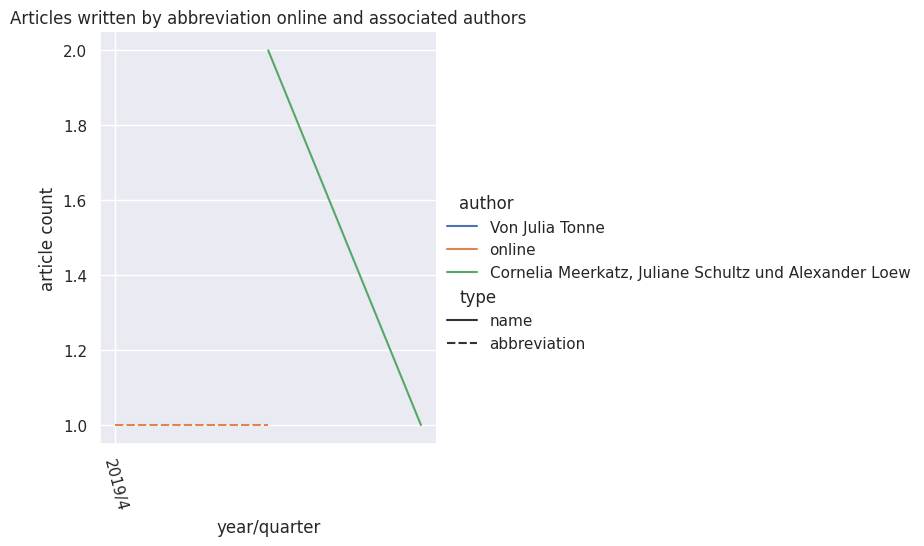

In [25]:
for row in author_abbreviation_pairs_with_lifespan_difference:
    abbr_authors = []
    abbr = row["abbreviation"]
    mapped_author = row["author"]
    abbr_neighbours = list(G.neighbors(abbr))
    for author in abbr_neighbours:
        rows = cur.execute('select ar.published_at from articles ar join article_authors aa on ar.id = aa.article_id join authors au on aa.author_id = au.id where au.name = ?', (author,)).fetchall()
        abbr_authors.extend([{"author": author, "type": "name", "published_at": row[0]} for row in rows])


    rows = cur.execute('select ar.published_at from articles ar join article_authors aa on ar.id = aa.article_id join authors au on aa.author_id = au.id where au.abbreviation = ?', (abbr,)).fetchall()
    abbr_authors.extend([{"author": abbr, "type": "abbreviation", "published_at": row[0]} for row in rows])

    abbr_authors = pd.DataFrame(columns=["author", "type", "published_at"], data=abbr_authors)

    # aggregate by quarter of the year
    abbr_authors['published_at'] = pd.to_datetime(abbr_authors['published_at'])
    abbr_authors['quarter'] = abbr_authors['published_at'].dt.quarter
    abbr_authors['year'] = abbr_authors['published_at'].dt.year
    abbr_authors['year_quarter'] = abbr_authors['year'].astype(str) + "/" + abbr_authors['quarter'].astype(str)
    abbr_authors['year_semester'] = abbr_authors['year'].astype(str) + "/" + abbr_authors['quarter'].apply(lambda x: 1 if x <= 2 else 2).astype(str)
    abbr_authors = abbr_authors.groupby(['year', 'year_quarter', 'author', 'type']).count()['published_at'].reset_index()
    # rename published at to count
    abbr_authors = abbr_authors.rename(columns={"published_at": "count"})

    plt.cla()
    plt.clf()
    sns.relplot(kind='line', data=abbr_authors, x='year_quarter', y='count', hue='author', style='type', errorbar=None)
    # set y title to article count
    plt.ylabel("article count")
    plt.xlabel("year/quarter")
    sns.set(rc={'figure.figsize':(14,10)})
    plt.xticks(rotation=-75)
    # set ticks to every 4th
    plt.xticks(np.arange(0, len(abbr_authors['year_quarter'].unique()), 4))
    #plt.tight_layout()
    plt.title(f'Articles written by abbreviation {abbr} and associated authors')
    plt.savefig(f'../reports/figures/author_abbreviation_pairs_with_lifespan_difference/articles_written_by_abbreviation_{abbr}_and_mapped_author_{"_".join(mapped_author.split(" "))}_and_associated_authors.png',bbox_inches='tight',dpi=300)
    plt.close()

We conclude that there are authors (Inge Engelhardt with abbreviation "ie", compare report "articles_written_by_abbreviation_ie_and_mapped_author_Inge_Engelhardt_and_associated_authors") where the abbreviation matches the authors writing frequency but only for a fraction of the author's writing time. Likely, the abbreviation was introduced later. Maybe the author did not have an abbreviation before. In this example we also see that the authors name has (likely) changed but the old one is still used. Thus, the abbreviation would have to match both the authors.

In [ ]:
print(f"new graph has {len(g_new.nodes)} nodes and {len(g_new.edges)} edges")

There are abbr nodes that were not matched with any author. That's why we have: edges * 2 < nodes.

In [ ]:
# test that only abbrs are not in the matches nodes
for node in g_new.nodes:
    if g_new.degree(node) == 0 and node in author_list:
        print(f"author node {node} has no edges")
    elif g_new.degree(node) == 0 and node in abbr_list:
        print(f"abbreviation node {node} has no edges")

In [ ]:
# list the abbreviations that were connected to the author that the edges with zero edges were pointing to
# so we can e.g. check if we need to enable multiple abbreviations for the same author
for node in g_new.nodes:
    if g_new.degree(node) == 0:
        # check the authors of the old graph that were pointing to this abbreviation
        old_neighbors = G.neighbors(node)
        for old_neighbor in old_neighbors:
            print(f"new neighbors of old abbr {node} node neighbors {old_neighbor} are {list(g_new.neighbors(old_neighbor))}")


From this we do see that some authors have several abbreviations
For example: krysta brown has probably two abbreviations: "krysta" and "brown"

In [ ]:
print(f"{(len(g_new.edges))} abbreviations were matched")
print(f"There are {len(g_new.nodes) - (len(g_new.edges) * 2)} abbreviations that were not matched")

In [ ]:
# print not matched abbreviations
print([node for node in g_new.nodes if g_new.degree(node) == 0])

In [ ]:
# test if these abbreviations have only one edge in the old graph. If so, we can append them to that author.
unmatched_abbrs_with_only_one_edge = [node for node in g_new.nodes if g_new.degree(node) == 0 and len(list(G.neighbors(node))) == 1]
print(f"{len(unmatched_abbrs_with_only_one_edge)} abbreviations have only one edge in the old graph")

# list remaining abbreviations
remaining_abbrs = [node for node in g_new.nodes if g_new.degree(node) == 0 and len(list(G.neighbors(node))) > 1]
print(remaining_abbrs)

We conclude, that most of the unmatched abbreviations were only connected to one author originally. That means that we can append them to that author because we know now that authors can have multiple abbreviations.